In [1]:
import pandas as pd
import numpy as np

### After feature selection, creating a list of columns which were selected

In [2]:
cols_prop = ['taxvaluedollarcnt',
              'landtaxvaluedollarcnt',
              'structuretaxvaluedollarcnt',
              'finishedsquarefeet12',
              'taxamount',
              'calculatedfinishedsquarefeet',
              'lotsizesquarefeet',
              'bathroomcnt',
              'latitude',
              'longitude',
              'parcelid']

#### Reading the columns from the files

In [3]:
prop_2016 = pd.read_csv('data/properties_2016.csv', usecols=cols_prop)

In [4]:
prop_2017 = pd.read_csv('data/properties_2017.csv', usecols=cols_prop)

In [5]:
train_2016 = pd.read_csv('data/train_2016_v2.csv', usecols=['logerror', 'parcelid'])

In [6]:
train_2017 = pd.read_csv('data/train_2017.csv', usecols=['logerror', 'parcelid'])

### Reducing the size of dataframes

#### Setting up functions

In [7]:
def get_min_memory_type(colobj, verbose=0):
    orig_type = colobj.dtype
    new_types = ["uint8", "int8", "uint16", "int16", 'float16', "uint32", "int32", 'float32']
    if (orig_type not in new_types and orig_type not in ["int64", "uint64", "float64"]):
        if (verbose > 0):
            print("Type {} of column {} is unsupported".format(orig_type, colobj.name))
        return orig_type

    for new_type in new_types:
        yes_min = colobj.min() == colobj.min().astype(new_type).astype(orig_type)
        yes_max = colobj.max() == colobj.max().astype(new_type).astype(orig_type)
        if (yes_min and yes_max):
            return new_type

    if (verbose > 0):
        print("No optimisation found for {} column of {} type".format(colobj.name, orig_type))
    return orig_type


def reduce_mem_usage(df, exclude=[], verbose=0):
    start_mem_usg = df.memory_usage().sum() / 1024 ** 2
    if (verbose > 0):
        print("Memory usage before :", start_mem_usg, " MB")

    for colname in df.columns:
        if (colname not in exclude):
            colobj = getattr(df, colname)
            new_type = get_min_memory_type(colobj, verbose)
            if (new_type != colobj.dtype):
                if (verbose > 0):
                    print("Converting {} column from {} to {}".format(colname, colobj.dtype, new_type))
                df[colname] = df[colname].astype(new_type)

    end_mem_usg = df.memory_usage().sum() / 1024 ** 2

    if (verbose > 0):
        print("Memory usage after :", end_mem_usg, " MB")

    mem_usg_diff_prc = float((end_mem_usg - start_mem_usg)) * 100 / start_mem_usg

    if (verbose > 0):
        if (end_mem_usg < start_mem_usg):
            print("Memory gain: {0:0.2f}%".format(-mem_usg_diff_prc))
        else:
            print("Memory loss: {0:0.2f}%".format(mem_usg_diff_prc))

    return -mem_usg_diff_prc

def fillna_mean(df, cols):
    for col in cols:
        mean_values = df[[col]].mean(axis=0)
#         print(col, mean_values[col])
        df[col].fillna(mean_values[col], inplace=True)

#### Filling the Nan with means

In [8]:
fillna_mean(prop_2016, cols_prop)

In [9]:
fillna_mean(prop_2017, cols_prop)

#### Reduce the memory usage for properties file

In [10]:
reduce_mem_usage(prop_2016,[],0)

48.863621483152272

In [11]:
reduce_mem_usage(prop_2017,[],0)

48.863621483152272

### Merging the properties with the train data

In [12]:
cols_prop.append('logerror')
cols_prop

['taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'structuretaxvaluedollarcnt',
 'finishedsquarefeet12',
 'taxamount',
 'calculatedfinishedsquarefeet',
 'lotsizesquarefeet',
 'bathroomcnt',
 'latitude',
 'longitude',
 'parcelid',
 'logerror']

In [13]:
prop16_train16 = pd.merge(train_2016,prop_2016, on='parcelid', how='left')
prop16_train17 = pd.merge(train_2017,prop_2016, on='parcelid', how='left')
prop17_train16 = pd.merge(train_2016,prop_2017, on='parcelid', how='left')
prop17_train17 = pd.merge(train_2017,prop_2017, on='parcelid', how='left')

In [14]:
prop16_train16.head()

,parcelid,logerror,bathroomcnt,calculatedfinishedsquarefeet,finishedsquarefeet12,latitude,longitude,lotsizesquarefeet,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
0,11016594,0.0276,2,1684,1684,34280990,-118488536,7528,122754,360170,237416,6735.88
1,14366692,-0.1684,3,2263,2263,33668120,-117677556,3643,346458,585529,239071,10153.02
2,12098116,-0.0040,3,2217,2217,34136312,-118175032,11423,61994,119906,57912,11484.48
3,12643413,0.0218,2,839,839,33755800,-118309000,70859,171518,244880,73362,3048.74
4,14432541,-0.0050,2,2283,2283,33485643,-117700234,6000,169574,434551,264977,5488.96


### Normalizing the data with min_max_scalar

In [15]:
from sklearn.preprocessing import MinMaxScaler
min_max_scalar = MinMaxScaler()

In [16]:
prop16_train16[cols_prop] = min_max_scalar.fit_transform(prop16_train16[cols_prop])

In [17]:
prop16_train17[cols_prop] = min_max_scalar.fit_transform(prop16_train17[cols_prop])

In [18]:
prop17_train16[cols_prop] = min_max_scalar.fit_transform(prop17_train16[cols_prop])

In [19]:
prop17_train17[cols_prop] = min_max_scalar.fit_transform(prop17_train17[cols_prop])

In [20]:
prop16_train16.head()

,parcelid,logerror,bathroomcnt,calculatedfinishedsquarefeet,finishedsquarefeet12,latitude,longitude,lotsizesquarefeet,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
0,0.002002,0.495890,0.10,0.073970,0.084054,0.637696,0.506793,0.001056,0.012330,0.012978,0.009690,0.020774
1,0.024006,0.474909,0.15,0.099433,0.112988,0.222673,0.935216,0.000499,0.034817,0.021099,0.009757,0.031390
2,0.009106,0.492507,0.15,0.097410,0.110689,0.539723,0.672410,0.001615,0.006222,0.004320,0.002363,0.035526
3,0.012688,0.495269,0.10,0.036809,0.041827,0.282049,0.601638,0.010141,0.017231,0.008824,0.002993,0.009319
4,0.024439,0.492400,0.10,0.100312,0.113987,0.099104,0.923236,0.000837,0.017036,0.015659,0.010814,0.016900


### Preparing the training and testing set

In [21]:
test1 = prop16_train16.iloc[0:9000]
test2 = prop16_train17.iloc[7000:14000]
test3 = prop17_train16.iloc[18000:27000]
test4 = prop17_train17.iloc[21000:28000]

In [22]:
train1 = prop16_train16.drop(prop16_train16.index[0:9000])
train2 = prop16_train17.drop(prop16_train17.index[7000:14000])
train3 = prop17_train16.drop(prop17_train16.index[18000:27000])
train4 = prop17_train17.drop(prop17_train17.index[21000:28000])

### Training the data

In [95]:
def build_model():
    global xgb_params
    xgb_params = {
        'eta': 0.007,
        'max_depth': 6, 
        'subsample': 0.6,
        'objective': 'reg:linear',
        'eval_metric': 'mae',
        'lambda': 9.0,
        'alpha': 0.8,
        'colsample_bytree': 0.7,
        'silent': 1
    }

In [96]:
build_model()

#### Preparing the training matrices

In [25]:
x_train1 = train1.drop('parcelid', axis=1)
x_train2 = train2.drop('parcelid', axis=1)
x_train3 = train3.drop('parcelid', axis=1)
x_train4 = train4.drop('parcelid', axis=1)

#### Removing the left out Nan values

In [26]:
x_train1 = x_train1.dropna(axis=0, how='any')
x_train2 = x_train2.dropna(axis=0, how='any')
x_train3 = x_train3.dropna(axis=0, how='any')
x_train4 = x_train4.dropna(axis=0, how='any')

#### Preparing the final matrices for the model

In [137]:
Y1 = x_train1['logerror'].values
Y2 = x_train2['logerror'].values
Y3 = x_train3['logerror'].values
Y4 = x_train4['logerror'].values
X1 = x_train1.drop(['logerror'], axis=1).as_matrix()
X2 = x_train2.drop(['logerror'], axis=1).as_matrix()
X3 = x_train3.drop(['logerror'], axis=1).as_matrix()
X4 = x_train4.drop(['logerror'], axis=1).as_matrix()

### Training the data

In [28]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning

In [29]:
import xgboost as xgb

In [138]:
X = np.concatenate((X1,X2,X3,X4), axis=0)
Y = np.concatenate((Y1,Y2,Y3,Y4), axis=0)

In [139]:
Y.shape

(303776,)

In [140]:
XDB = xgb.DMatrix(X, label=Y)

In [89]:
evals = [(XDB,'train'),(XDB,'valid')]

In [73]:
xgb_clf = xgb.train(xgb_params, XDB, num_boost_round=10000, evals=evals, early_stopping_rounds=100, verbose_eval=10)

[0]	train-mae:0.019558	valid-mae:0.019558
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.018576	valid-mae:0.018576
[20]	train-mae:0.017658	valid-mae:0.017658
[30]	train-mae:0.01681	valid-mae:0.01681
[40]	train-mae:0.016025	valid-mae:0.016025
[50]	train-mae:0.015303	valid-mae:0.015303
[60]	train-mae:0.01465	valid-mae:0.01465
[70]	train-mae:0.014036	valid-mae:0.014036
[80]	train-mae:0.013475	valid-mae:0.013475
[90]	train-mae:0.012953	valid-mae:0.012953
[100]	train-mae:0.012466	valid-mae:0.012466
[110]	train-mae:0.012032	valid-mae:0.012032
[120]	train-mae:0.011618	valid-mae:0.011618
[130]	train-mae:0.011243	valid-mae:0.011243
[140]	train-mae:0.010906	valid-mae:0.010906
[150]	train-mae:0.010596	valid-mae:0.010596
[160]	train-mae:0.010302	valid-mae:0.010302
[170]	train-mae:0.010041	valid-mae:0.010041
[180]	train-mae:0.009798	valid-mae:0.009798
[190]	train-mae:0.00957	valid-mae:0

[1830]	train-mae:0.007148	valid-mae:0.007148
[1840]	train-mae:0.007148	valid-mae:0.007148
[1850]	train-mae:0.007147	valid-mae:0.007147
[1860]	train-mae:0.007147	valid-mae:0.007147
[1870]	train-mae:0.007146	valid-mae:0.007146
[1880]	train-mae:0.007146	valid-mae:0.007146
[1890]	train-mae:0.007146	valid-mae:0.007146
[1900]	train-mae:0.007146	valid-mae:0.007146
[1910]	train-mae:0.007145	valid-mae:0.007145
[1920]	train-mae:0.007145	valid-mae:0.007145
[1930]	train-mae:0.007145	valid-mae:0.007145
[1940]	train-mae:0.007144	valid-mae:0.007144
[1950]	train-mae:0.007144	valid-mae:0.007144
[1960]	train-mae:0.007144	valid-mae:0.007144
[1970]	train-mae:0.007143	valid-mae:0.007143
[1980]	train-mae:0.007143	valid-mae:0.007143
[1990]	train-mae:0.007143	valid-mae:0.007143
[2000]	train-mae:0.007143	valid-mae:0.007143
[2010]	train-mae:0.007142	valid-mae:0.007142
[2020]	train-mae:0.007142	valid-mae:0.007142
[2030]	train-mae:0.007142	valid-mae:0.007142
[2040]	train-mae:0.007142	valid-mae:0.007142
[2050]	tra

[3660]	train-mae:0.007107	valid-mae:0.007107
[3670]	train-mae:0.007107	valid-mae:0.007107
[3680]	train-mae:0.007107	valid-mae:0.007107
[3690]	train-mae:0.007107	valid-mae:0.007107
[3700]	train-mae:0.007106	valid-mae:0.007106
[3710]	train-mae:0.007106	valid-mae:0.007106
[3720]	train-mae:0.007106	valid-mae:0.007106
[3730]	train-mae:0.007106	valid-mae:0.007106
[3740]	train-mae:0.007106	valid-mae:0.007106
[3750]	train-mae:0.007106	valid-mae:0.007106
[3760]	train-mae:0.007106	valid-mae:0.007106
[3770]	train-mae:0.007105	valid-mae:0.007105
[3780]	train-mae:0.007105	valid-mae:0.007105
[3790]	train-mae:0.007105	valid-mae:0.007105
[3800]	train-mae:0.007105	valid-mae:0.007105
[3810]	train-mae:0.007104	valid-mae:0.007104
[3820]	train-mae:0.007104	valid-mae:0.007104
[3830]	train-mae:0.007104	valid-mae:0.007104
[3840]	train-mae:0.007104	valid-mae:0.007104
[3850]	train-mae:0.007104	valid-mae:0.007104
[3860]	train-mae:0.007103	valid-mae:0.007103
[3870]	train-mae:0.007103	valid-mae:0.007103
[3880]	tra

[5500]	train-mae:0.007077	valid-mae:0.007077
[5510]	train-mae:0.007077	valid-mae:0.007077
[5520]	train-mae:0.007077	valid-mae:0.007077
[5530]	train-mae:0.007077	valid-mae:0.007077
[5540]	train-mae:0.007076	valid-mae:0.007076
[5550]	train-mae:0.007076	valid-mae:0.007076
[5560]	train-mae:0.007076	valid-mae:0.007076
[5570]	train-mae:0.007076	valid-mae:0.007076
[5580]	train-mae:0.007076	valid-mae:0.007076
[5590]	train-mae:0.007076	valid-mae:0.007076
[5600]	train-mae:0.007076	valid-mae:0.007076
[5610]	train-mae:0.007075	valid-mae:0.007075
[5620]	train-mae:0.007075	valid-mae:0.007075
[5630]	train-mae:0.007075	valid-mae:0.007075
[5640]	train-mae:0.007075	valid-mae:0.007075
[5650]	train-mae:0.007075	valid-mae:0.007075
[5660]	train-mae:0.007075	valid-mae:0.007075
[5670]	train-mae:0.007075	valid-mae:0.007075
[5680]	train-mae:0.007075	valid-mae:0.007075
[5690]	train-mae:0.007075	valid-mae:0.007075
[5700]	train-mae:0.007075	valid-mae:0.007075
[5710]	train-mae:0.007074	valid-mae:0.007074
[5720]	tra

[7330]	train-mae:0.007051	valid-mae:0.007051
[7340]	train-mae:0.007051	valid-mae:0.007051
[7350]	train-mae:0.007051	valid-mae:0.007051
[7360]	train-mae:0.007051	valid-mae:0.007051
[7370]	train-mae:0.007051	valid-mae:0.007051
[7380]	train-mae:0.00705	valid-mae:0.00705
[7390]	train-mae:0.007051	valid-mae:0.007051
[7400]	train-mae:0.007051	valid-mae:0.007051
[7410]	train-mae:0.007051	valid-mae:0.007051
[7420]	train-mae:0.00705	valid-mae:0.00705
[7430]	train-mae:0.00705	valid-mae:0.00705
[7440]	train-mae:0.00705	valid-mae:0.00705
[7450]	train-mae:0.00705	valid-mae:0.00705
[7460]	train-mae:0.00705	valid-mae:0.00705
[7470]	train-mae:0.00705	valid-mae:0.00705
[7480]	train-mae:0.00705	valid-mae:0.00705
Stopping. Best iteration:
[7380]	train-mae:0.00705	valid-mae:0.00705



In [74]:
xgb_clf.save_model('xgb_trained.model')

In [136]:
Y1 = test1['logerror'].values
Y2 = test2['logerror'].values
Y3 = test3['logerror'].values
Y4 = test4['logerror'].values
Xtest1 = test1.drop(['logerror','parcelid'], axis=1).as_matrix()
Xtest2 = test2.drop(['logerror','parcelid'], axis=1).as_matrix()
Xtest3 = test3.drop(['logerror','parcelid'], axis=1).as_matrix()
Xtest4 = test4.drop(['logerror','parcelid'], axis=1).as_matrix()

In [38]:
Xtest = np.concatenate((Xtest1,Xtest2,Xtest3,Xtest4), axis=0)

In [39]:
Xtest = xgb.DMatrix(Xtest)

#### Loading the saved model

In [91]:
xgb_clf = xgb.Booster()

In [92]:
xgb_clf.load_model('xgb_trained.model')

AttributeError: 'XGBClassifier' object has no attribute 'load_model'

In [40]:
pred = xgb_clf.predict(Xtest)

#### Evaluating the trained model

In [41]:
from sklearn.metrics import mean_squared_error, r2_score
Y = np.concatenate((Y1,Y2,Y3,Y4), axis=0)

In [42]:
print(mean_squared_error(Y,pred))
print(r2_score(Y,pred))

0.000316820401206
0.324885477489


### Fetching the weights from feature selection

In [43]:
weights = [0.47,0.42,0.35,0.31,0.29,0.21,0.19,0.12,0.08,0.08]

### Calculating the pairwise distance

In [53]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('wminkowski',p=2,w=weights)
Dist_matrix = dist.pairwise(X[0:1000,:])

In [54]:
Dist_matrix.shape

(1000, 1000)

### Clustering the data

In [59]:
def dist_func(v1,v2):
    return np.sqrt(np.sum(weights*(v1-v2)**2))

In [60]:
from sklearn.cluster import DBSCAN

In [67]:
db = DBSCAN(min_samples=20, eps=0.01, metric=dist_func).fit(X[0:10000,:])

In [74]:
n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_clusters

16

### Permutation Testing

In [78]:
from sklearn.model_selection import permutation_test_score

In [111]:
Xperm = np.concatenate((Xtest1,Xtest2,Xtest3,Xtest4), axis=0)

In [144]:
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold

In [145]:
svr = SVR()
cv = StratifiedKFold(2)

In [161]:
score, permutation_scores, pvalue = permutation_test_score(
    svr, X[0:100000,:], Y[0:100000], cv=cv, n_permutations=100, n_jobs=8, verbose=1)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  6.4min


KeyboardInterrupt: 

In [157]:
print("Classification score %s (pvalue : %s)" % (score, pvalue))

Classification score -2.05029617911 (pvalue : 0.00990099009901)


In [158]:
import matplotlib.pyplot as plt

In [159]:
n_classes = np.unique(Y).size

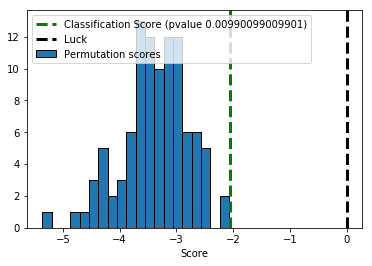

In [160]:
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
# BUG: vlines(..., linestyle='--') fails on older versions of matplotlib
# plt.vlines(score, ylim[0], ylim[1], linestyle='--',
#          color='g', linewidth=3, label='Classification Score'
#          ' (pvalue %s)' % pvalue)
# plt.vlines(1.0 / n_classes, ylim[0], ylim[1], linestyle='--',
#          color='k', linewidth=3, label='Luck')
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()

In [155]:
Y.shape

(303776,)